# Churn Prediction Model

This notebook implements a churn prediction model for a music streaming service.

## Day 1: Data Pipeline & Feature Engineering Foundation

**Goal**: Transform event logs into user-level features for prediction.

## Step 1.1: Load Data and Create Labels

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

# Load data
print("Loading data...")
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

print(f"Train: {train.shape[0]:,} rows")
print(f"Test: {test.shape[0]:,} rows")

Loading data...
Train: 17,499,636 rows
Test: 4,393,179 rows


In [2]:
# Create user-level churn labels
churned_users = train[train['page'] == 'Cancellation Confirmation']['userId'].unique()
all_users = train['userId'].unique()

print(f"Total users: {len(all_users):,}")
print(f"Churned users: {len(churned_users):,}")
print(f"Churn rate: {len(churned_users)/len(all_users):.2%}")

# Get churn timestamps for temporal slicing later
churn_times = train[train['page'] == 'Cancellation Confirmation'].groupby('userId')['time'].first()
print(f"\nChurn times recorded for {len(churn_times):,} users")

Total users: 19,140
Churned users: 4,271
Churn rate: 22.31%

Churn times recorded for 4,271 users


## Step 1.2: Vectorized Feature Engineering

Using `groupby` and vectorized pandas operations for ~100x speedup over row-by-row processing.

Feature categories:
- **Engagement**: total events, songs, sessions
- **Behavioral ratios**: thumbs up/down per song, error rate
- **Temporal**: days active, recency, activity trend
- **Subscription**: paid/free status, level changes, downgrade/upgrade events
- **Content diversity**: unique songs/artists, listen time

In [3]:
def create_user_features_vectorized(df, churn_times_series=None):
    """
    Vectorized feature engineering using groupby operations.
    ~100x faster than row-by-row processing.

    Parameters:
    - df: DataFrame with events
    - churn_times_series: Series with userId as index, churn time as value (for Cancel page handling)

    Returns:
    - DataFrame with one row per user
    """
    print("Computing basic aggregations...")

    # ===== BASIC AGGREGATIONS =====
    basic_agg = df.groupby('userId').agg(
        total_events=('page', 'count'),
        total_sessions=('sessionId', 'nunique'),
        time_min=('time', 'min'),
        time_max=('time', 'max'),
        registration=('registration', 'first'),
        gender=('gender', 'first'),
        location=('location', 'first'),
        level_last=('level', 'last'),
    )

    # ===== PAGE COUNTS (using crosstab for efficiency) =====
    print("Computing page counts...")
    important_pages = ['NextSong', 'Thumbs Up', 'Thumbs Down', 'Add to Playlist',
                       'Add Friend', 'Downgrade', 'Upgrade', 'Error', 'Help',
                       'Home', 'Settings', 'Roll Advert', 'Logout']

    # Filter to important pages only, then crosstab
    page_df = df[df['page'].isin(important_pages)][['userId', 'page']]
    page_counts = pd.crosstab(page_df['userId'], page_df['page'])

    # Ensure all important pages exist as columns
    for page in important_pages:
        if page not in page_counts.columns:
            page_counts[page] = 0

    # Rename columns
    page_counts.columns = [f'page_{col.lower().replace(" ", "_")}' for col in page_counts.columns]

    # ===== SESSION STATISTICS =====
    print("Computing session statistics...")
    session_sizes = df.groupby(['userId', 'sessionId']).size().reset_index(name='session_length')
    session_stats = session_sizes.groupby('userId')['session_length'].agg(
        avg_session_length='mean',
        max_session_length='max',
        std_session_length='std'
    ).fillna(0)

    # ===== SONG-RELATED FEATURES =====
    print("Computing song features...")
    songs_df = df[df['page'] == 'NextSong']

    song_agg = songs_df.groupby('userId').agg(
        total_songs=('page', 'count'),
        unique_songs=('song', 'nunique'),
        unique_artists=('artist', 'nunique'),
        avg_song_length=('length', lambda x: x.clip(upper=1200).mean()),
        total_listen_time=('length', lambda x: x.clip(upper=1200).sum()),
        std_song_length=('length', lambda x: x.clip(upper=1200).std()),
    ).fillna(0)

    # ===== LEVEL CHANGES =====
    print("Computing subscription features...")
    df_sorted = df.sort_values(['userId', 'time'])
    df_sorted['level_changed'] = (df_sorted['level'] != df_sorted.groupby('userId')['level'].shift()).astype(int)
    level_changes = df_sorted.groupby('userId')['level_changed'].sum() - 1  # subtract 1 for first row
    level_changes = level_changes.clip(lower=0)

    # Paid events ratio
    df_sorted['is_paid_event'] = (df_sorted['level'] == 'paid').astype(int)
    paid_ratio = df_sorted.groupby('userId')['is_paid_event'].mean()

    # ===== ACTIVITY TREND =====
    print("Computing temporal features...")
    def compute_activity_trend(group):
        if len(group) <= 1:
            return 0
        mid_time = group['time'].min() + (group['time'].max() - group['time'].min()) / 2
        first_half = (group['time'] <= mid_time).sum()
        second_half = (group['time'] > mid_time).sum()
        return (second_half - first_half) / max(first_half, 1)

    activity_trend = df.groupby('userId').apply(compute_activity_trend, include_groups=False)

    # ===== CANCEL PAGE VISITS (with 12-hour exclusion) =====
    print("Computing cancel page visits...")
    cancel_df = df[df['page'] == 'Cancel'][['userId', 'time']].copy()

    if churn_times_series is not None and len(cancel_df) > 0:
        # Merge churn times
        cancel_df = cancel_df.merge(
            churn_times_series.rename('churn_time').reset_index(),
            on='userId',
            how='left'
        )
        # Count only cancels > 12 hours before churn (or all if no churn)
        cancel_df['is_safe'] = (
            cancel_df['churn_time'].isna() |
            (cancel_df['time'] < cancel_df['churn_time'] - pd.Timedelta(hours=12))
        )
        cancel_page_visits = cancel_df[cancel_df['is_safe']].groupby('userId').size()
    else:
        cancel_page_visits = cancel_df.groupby('userId').size()

    # ===== COMBINE ALL FEATURES =====
    print("Combining features...")
    features = basic_agg.copy()

    # Join page counts
    features = features.join(page_counts, how='left').fillna(0)

    # Join session stats
    features = features.join(session_stats, how='left').fillna(0)

    # Join song features
    features = features.join(song_agg, how='left').fillna(0)

    # Add level changes and paid ratio
    features['level_changes'] = level_changes
    features['paid_ratio'] = paid_ratio

    # Add activity trend
    features['activity_trend'] = activity_trend

    # Add cancel page visits
    features['cancel_page_visits'] = cancel_page_visits.reindex(features.index).fillna(0).astype(int)

    # ===== COMPUTE DERIVED FEATURES =====
    print("Computing derived features...")

    # Temporal features
    features['days_active'] = (features['time_max'] - features['time_min']).dt.days + 1
    features['days_since_registration'] = (features['time_max'] - features['registration']).dt.days
    features['events_per_day'] = features['total_events'] / features['days_active'].clip(lower=1)
    features['songs_per_day'] = features['total_songs'] / features['days_active'].clip(lower=1)

    # Subscription features
    features['is_paid'] = (features['level_last'] == 'paid').astype(int)
    features['has_downgrade'] = (features['page_downgrade'] > 0).astype(int)
    features['has_upgrade'] = (features['page_upgrade'] > 0).astype(int)

    # Behavioral ratios
    features['thumbs_up_ratio'] = features['page_thumbs_up'] / features['total_songs'].clip(lower=1)
    features['thumbs_down_ratio'] = features['page_thumbs_down'] / features['total_songs'].clip(lower=1)
    features['playlist_add_ratio'] = features['page_add_to_playlist'] / features['total_songs'].clip(lower=1)
    features['error_rate'] = features['page_error'] / features['total_events'].clip(lower=1)
    features['ad_ratio'] = features['page_roll_advert'] / features['total_songs'].clip(lower=1)

    # Song repeat ratio
    features['song_repeat_ratio'] = features['total_songs'] / features['unique_songs'].clip(lower=1)

    # Fix ratios for users with 0 songs
    zero_songs = features['total_songs'] == 0
    ratio_cols = ['thumbs_up_ratio', 'thumbs_down_ratio', 'playlist_add_ratio', 'ad_ratio', 'song_repeat_ratio']
    features.loc[zero_songs, ratio_cols] = 0

    # ===== EXTRACT STATE FROM LOCATION =====
    def extract_state(loc):
        if pd.isna(loc) or loc == 'Unknown':
            return 'Unknown'
        if ',' in str(loc):
            return str(loc).split(',')[-1].strip()[:2]
        return 'Unknown'

    features['state'] = features['location'].apply(extract_state)

    # Fix gender - ensure it's always a string (handles mixed types from NaN)
    features['gender'] = features['gender'].fillna('Unknown').astype(str)

    # ===== CLEANUP =====
    # Drop intermediate columns
    features = features.drop(columns=['time_min', 'time_max', 'registration', 'location', 'level_last'])

    # Reset index to make userId a column
    features = features.reset_index()

    print(f"Done! Created {len(features)} user feature rows with {len(features.columns)-1} features")
    return features

## Step 1.3: Create Training Dataset

In [4]:
# Create features for all training users using vectorized operations
print("Creating features for training users...")
print(f"Processing {len(all_users):,} users from {len(train):,} events\n")

import time
start_time = time.time()

train_features = create_user_features_vectorized(train, churn_times_series=churn_times)

elapsed = time.time() - start_time
print(f"\nCompleted in {elapsed:.1f} seconds")

# Add churn labels
churned_set = set(churned_users)
train_features['churn'] = train_features['userId'].apply(lambda x: 1 if x in churned_set else 0)

print(f"\nTraining set shape: {train_features.shape}")
print(f"Churn distribution:\n{train_features['churn'].value_counts()}")

Creating features for training users...
Processing 19,140 users from 17,499,636 events

Computing basic aggregations...
Computing page counts...
Computing session statistics...
Computing song features...
Computing subscription features...
Computing temporal features...
Computing cancel page visits...
Combining features...
Computing derived features...
Done! Created 19140 user feature rows with 43 features

Completed in 32.9 seconds

Training set shape: (19140, 45)
Churn distribution:
churn
0    14869
1     4271
Name: count, dtype: int64


In [5]:
# Verify feature quality
print("Feature columns:")
print(train_features.columns.tolist())
print(f"\nTotal features: {len(train_features.columns) - 2}")  # excluding userId and churn

# Check for any missing values
missing = train_features.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values:")
    print(missing[missing > 0])
else:
    print("\nNo missing values in features!")

Feature columns:
['userId', 'total_events', 'total_sessions', 'gender', 'page_add_friend', 'page_add_to_playlist', 'page_downgrade', 'page_error', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_roll_advert', 'page_settings', 'page_thumbs_down', 'page_thumbs_up', 'page_upgrade', 'avg_session_length', 'max_session_length', 'std_session_length', 'total_songs', 'unique_songs', 'unique_artists', 'avg_song_length', 'total_listen_time', 'std_song_length', 'level_changes', 'paid_ratio', 'activity_trend', 'cancel_page_visits', 'days_active', 'days_since_registration', 'events_per_day', 'songs_per_day', 'is_paid', 'has_downgrade', 'has_upgrade', 'thumbs_up_ratio', 'thumbs_down_ratio', 'playlist_add_ratio', 'error_rate', 'ad_ratio', 'song_repeat_ratio', 'state', 'churn']

Total features: 43

No missing values in features!


In [6]:
# Basic statistics for key features
key_features = ['total_events', 'total_songs', 'total_sessions', 'days_active',
                'thumbs_down_ratio', 'error_rate', 'has_downgrade', 'activity_trend']

print("Key feature statistics:")
train_features[key_features].describe()

Key feature statistics:


,total_events,total_songs,total_sessions,days_active,thumbs_down_ratio,error_rate,has_downgrade,activity_trend
count,19140.000000,19140.000000,19140.000000,19140.000000,19140.000000,19140.000000,19140.000000,19140.000000
mean,914.296552,746.678840,10.885998,32.147910,0.013100,0.001019,0.636677,2.149112
std,1079.652218,898.682491,10.654959,15.689274,0.014867,0.002589,0.480969,16.869290
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-0.998270
25%,202.000000,155.000000,4.000000,21.000000,0.006939,0.000000,0.000000,-0.370469
50%,537.500000,428.000000,8.000000,37.000000,0.010383,0.000000,1.000000,0.111111
75%,1213.000000,991.000000,14.000000,45.000000,0.015185,0.001351,1.000000,1.136364
max,10998.000000,9248.000000,116.000000,50.000000,0.500000,0.111111,1.000000,934.000000


In [7]:
# Save training features
train_features.to_parquet('train_features.parquet', index=False)
print("Training features saved to train_features.parquet")

Training features saved to train_features.parquet


## Step 1.4: Create Test Dataset

In [8]:
# Create features for test users using vectorized operations
test_users = test['userId'].unique()
print(f"Creating features for {len(test_users):,} test users from {len(test):,} events\n")

start_time = time.time()

test_features = create_user_features_vectorized(test, churn_times_series=None)

elapsed = time.time() - start_time
print(f"\nCompleted in {elapsed:.1f} seconds")
print(f"Test set shape: {test_features.shape}")

Creating features for 2,904 test users from 4,393,179 events

Computing basic aggregations...
Computing page counts...
Computing session statistics...
Computing song features...
Computing subscription features...
Computing temporal features...
Computing cancel page visits...
Combining features...
Computing derived features...
Done! Created 2904 user feature rows with 43 features

Completed in 6.4 seconds
Test set shape: (2904, 44)


In [9]:
# Verify test features match train features (excluding churn column)
train_cols = set(train_features.columns) - {'churn'}
test_cols = set(test_features.columns)

if train_cols == test_cols:
    print("Feature columns match between train and test!")
else:
    print("Column differences:")
    print(f"  In train only: {train_cols - test_cols}")
    print(f"  In test only: {test_cols - train_cols}")

# Check for missing values in test
missing_test = test_features.isnull().sum()
if missing_test.sum() > 0:
    print("\nMissing values in test:")
    print(missing_test[missing_test > 0])
else:
    print("\nNo missing values in test features!")

Feature columns match between train and test!

No missing values in test features!


In [10]:
# Save test features
test_features.to_parquet('test_features.parquet', index=False)
print("Test features saved to test_features.parquet")

Test features saved to test_features.parquet


## Day 1 Summary

### Completed:
- Loaded train (17.5M events) and test (4.4M events) data
- Created user-level churn labels (22% churn rate)
- Built feature engineering function with 35+ features
- Created training features for 19,140 users
- Created test features for 2,904 users
- Saved features as parquet files

### Feature Categories:
| Category | Features |
|----------|----------|
| Engagement | total_events, total_songs, total_sessions, avg/max/std_session_length |
| Page counts | page_nextsong, page_thumbs_up/down, page_downgrade, etc. |
| Behavioral ratios | thumbs_up/down_ratio, playlist_add_ratio, error_rate, ad_ratio |
| Temporal | days_active, days_since_registration, events_per_day, activity_trend |
| Subscription | is_paid, level_changes, has_downgrade, has_upgrade, paid_ratio |
| Content | unique_songs/artists, avg_song_length, total_listen_time, song_repeat_ratio |
| Demographics | gender, state |

In [11]:
# Final summary
print("="*50)
print("DAY 1 COMPLETE")
print("="*50)
print(f"\nTraining set: {train_features.shape[0]:,} users, {train_features.shape[1]-2} features")
print(f"Test set: {test_features.shape[0]:,} users, {test_features.shape[1]-1} features")
print(f"\nChurn rate: {train_features['churn'].mean():.2%}")
print(f"\nFiles created:")
print("  - train_features.parquet")
print("  - test_features.parquet")

DAY 1 COMPLETE

Training set: 19,140 users, 43 features
Test set: 2,904 users, 43 features

Churn rate: 22.31%

Files created:
  - train_features.parquet
  - test_features.parquet


---

## Day 2: Baseline Models & Validation Strategy

**Goal**: Train baseline models, establish validation approach, analyze feature importance.

### Step 2.1: Load Features and Prepare Data

In [12]:
# Day 2 imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Load features (can start fresh from here if needed)
train_df = pd.read_parquet('train_features.parquet')
print(f"Loaded training features: {train_df.shape}")
print(f"Churn distribution:\n{train_df['churn'].value_counts()}")

Loaded training features: (19140, 45)
Churn distribution:
churn
0    14869
1     4271
Name: count, dtype: int64


In [13]:
# Separate features and target
X = train_df.drop(['userId', 'churn'], axis=1)
y = train_df['churn']

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nFeature types:")
print(X.dtypes.value_counts())

Features shape: (19140, 43)
Target distribution: {0: 14869, 1: 4271}

Feature types:
int64      23
float64    18
object      2
Name: count, dtype: int64


In [14]:
# Encode categorical features
# Gender: M, F, Unknown
le_gender = LabelEncoder()
X['gender'] = le_gender.fit_transform(X['gender'])
print(f"Gender classes: {list(le_gender.classes_)}")

# State: 50+ unique states
le_state = LabelEncoder()
X['state'] = le_state.fit_transform(X['state'])
print(f"State classes: {len(le_state.classes_)} unique states")

# Store encoders for later use with test data
print(f"\nAll features are now numeric: {X.dtypes.value_counts().to_dict()}")

Gender classes: ['F', 'M']
State classes: 51 unique states

All features are now numeric: {dtype('int64'): 25, dtype('float64'): 18}


In [15]:
# Create stratified train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {len(X_train):,} samples")
print(f"Validation set: {len(X_val):,} samples")
print(f"\nTrain churn rate: {y_train.mean():.2%}")
print(f"Val churn rate: {y_val.mean():.2%}")

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nFeatures scaled with StandardScaler")

Train set: 15,312 samples
Validation set: 3,828 samples

Train churn rate: 22.32%
Val churn rate: 22.31%

Features scaled with StandardScaler


### Step 2.2: Baseline Model - Logistic Regression

In [16]:
# Train Logistic Regression with balanced class weights
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_lr = lr.predict(X_val_scaled)
y_pred_lr_prob = lr.predict_proba(X_val_scaled)[:, 1]

print("="*50)
print("LOGISTIC REGRESSION RESULTS")
print("="*50)
print(f"\nAccuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred_lr, target_names=['Not Churned', 'Churned']))

LOGISTIC REGRESSION RESULTS

Accuracy: 0.8130

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.93      0.82      0.87      2974
     Churned       0.56      0.80      0.66       854

    accuracy                           0.81      3828
   macro avg       0.75      0.81      0.76      3828
weighted avg       0.85      0.81      0.82      3828



In [17]:
# Confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_val, y_pred_lr)
print("Confusion Matrix (Logistic Regression):")
print(f"                 Predicted")
print(f"                 No Churn  Churned")
print(f"Actual No Churn   {cm_lr[0,0]:5d}    {cm_lr[0,1]:5d}")
print(f"Actual Churned    {cm_lr[1,0]:5d}    {cm_lr[1,1]:5d}")

Confusion Matrix (Logistic Regression):
                 Predicted
                 No Churn  Churned
Actual No Churn    2429      545
Actual Churned      171      683


In [18]:
# Feature importance for Logistic Regression (absolute coefficients)
lr_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_[0],
    'abs_importance': np.abs(lr.coef_[0])
}).sort_values('abs_importance', ascending=False)

print("Top 15 Features (Logistic Regression):")
print(lr_importance[['feature', 'coefficient']].head(15).to_string(index=False))

Top 15 Features (Logistic Regression):
           feature  coefficient
    unique_artists     4.119405
       days_active    -1.892103
      total_events     1.885376
     page_nextsong    -1.511879
       total_songs    -1.511879
      unique_songs    -1.294645
 total_listen_time    -1.008247
    events_per_day     0.756516
avg_session_length    -0.710113
     has_downgrade     0.695490
          ad_ratio     0.654700
    page_downgrade     0.560229
std_session_length     0.516873
  page_roll_advert     0.512167
    page_thumbs_up    -0.450061


### Step 2.3: Baseline Model - Random Forest

In [19]:
# Train Random Forest (no scaling needed for tree models)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_rf = rf.predict(X_val)
y_pred_rf_prob = rf.predict_proba(X_val)[:, 1]

print("="*50)
print("RANDOM FOREST RESULTS")
print("="*50)
print(f"\nAccuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred_rf, target_names=['Not Churned', 'Churned']))

RANDOM FOREST RESULTS

Accuracy: 0.8710

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.92      0.91      0.92      2974
     Churned       0.71      0.72      0.71       854

    accuracy                           0.87      3828
   macro avg       0.81      0.82      0.81      3828
weighted avg       0.87      0.87      0.87      3828



In [20]:
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_val, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(f"                 Predicted")
print(f"                 No Churn  Churned")
print(f"Actual No Churn   {cm_rf[0,0]:5d}    {cm_rf[0,1]:5d}")
print(f"Actual Churned    {cm_rf[1,0]:5d}    {cm_rf[1,1]:5d}")

Confusion Matrix (Random Forest):
                 Predicted
                 No Churn  Churned
Actual No Churn    2720      254
Actual Churned      240      614


In [21]:
# Feature importance for Random Forest
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Features (Random Forest):")
print(rf_importance.head(15).to_string(index=False))

Top 15 Features (Random Forest):
                feature  importance
            days_active    0.252302
         events_per_day    0.102342
          songs_per_day    0.099815
days_since_registration    0.077013
               ad_ratio    0.037695
     avg_session_length    0.026338
        thumbs_up_ratio    0.025622
      thumbs_down_ratio    0.023152
      total_listen_time    0.019977
       page_roll_advert    0.019928
         page_thumbs_up    0.017524
         total_sessions    0.016857
           total_events    0.016756
     std_session_length    0.016393
           unique_songs    0.015646


### Step 2.4: Cross-Validation

In [22]:
# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running 5-fold stratified cross-validation...")
print("="*50)

# Logistic Regression CV (needs scaled features)
# Create a pipeline for proper CV with scaling
from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

lr_cv_scores = cross_val_score(lr_pipeline, X, y, cv=cv, scoring='accuracy')
print(f"\nLogistic Regression CV Accuracy: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std()*2:.4f})")
print(f"  Fold scores: {[f'{s:.4f}' for s in lr_cv_scores]}")

# Random Forest CV (no scaling needed)
rf_cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print(f"\nRandom Forest CV Accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std()*2:.4f})")
print(f"  Fold scores: {[f'{s:.4f}' for s in rf_cv_scores]}")

Running 5-fold stratified cross-validation...

Logistic Regression CV Accuracy: 0.8182 (+/- 0.0115)
  Fold scores: ['0.8197', '0.8069', '0.8205', '0.8203', '0.8234']

Random Forest CV Accuracy: 0.8707 (+/- 0.0047)
  Fold scores: ['0.8717', '0.8678', '0.8681', '0.8720', '0.8738']


### Step 2.5: Feature Importance Analysis

In [23]:
# Compare feature importance between models
import matplotlib.pyplot as plt

# Merge importance rankings
importance_comparison = lr_importance[['feature', 'abs_importance']].rename(
    columns={'abs_importance': 'lr_importance'}
).merge(
    rf_importance[['feature', 'importance']].rename(columns={'importance': 'rf_importance'}),
    on='feature'
)

# Normalize to 0-1 scale for comparison
importance_comparison['lr_normalized'] = importance_comparison['lr_importance'] / importance_comparison['lr_importance'].max()
importance_comparison['rf_normalized'] = importance_comparison['rf_importance'] / importance_comparison['rf_importance'].max()
importance_comparison['avg_importance'] = (importance_comparison['lr_normalized'] + importance_comparison['rf_normalized']) / 2
importance_comparison = importance_comparison.sort_values('avg_importance', ascending=False)

print("Top 15 Features (Combined Ranking):")
print(importance_comparison[['feature', 'lr_normalized', 'rf_normalized', 'avg_importance']].head(15).to_string(index=False))

Top 15 Features (Combined Ranking):
                feature  lr_normalized  rf_normalized  avg_importance
            days_active       0.459315       1.000000        0.729657
         unique_artists       1.000000       0.052925        0.526462
         events_per_day       0.183647       0.405633        0.294640
           total_events       0.457682       0.066413        0.262047
          songs_per_day       0.097633       0.395618        0.246625
            total_songs       0.367014       0.061813        0.214413
          page_nextsong       0.367014       0.059353        0.213184
           unique_songs       0.314280       0.062014        0.188147
days_since_registration       0.038978       0.305240        0.172109
      total_listen_time       0.244755       0.079178        0.161967
               ad_ratio       0.158931       0.149404        0.154167
     avg_session_length       0.172382       0.104392        0.138387
          has_downgrade       0.168833       0.041954 

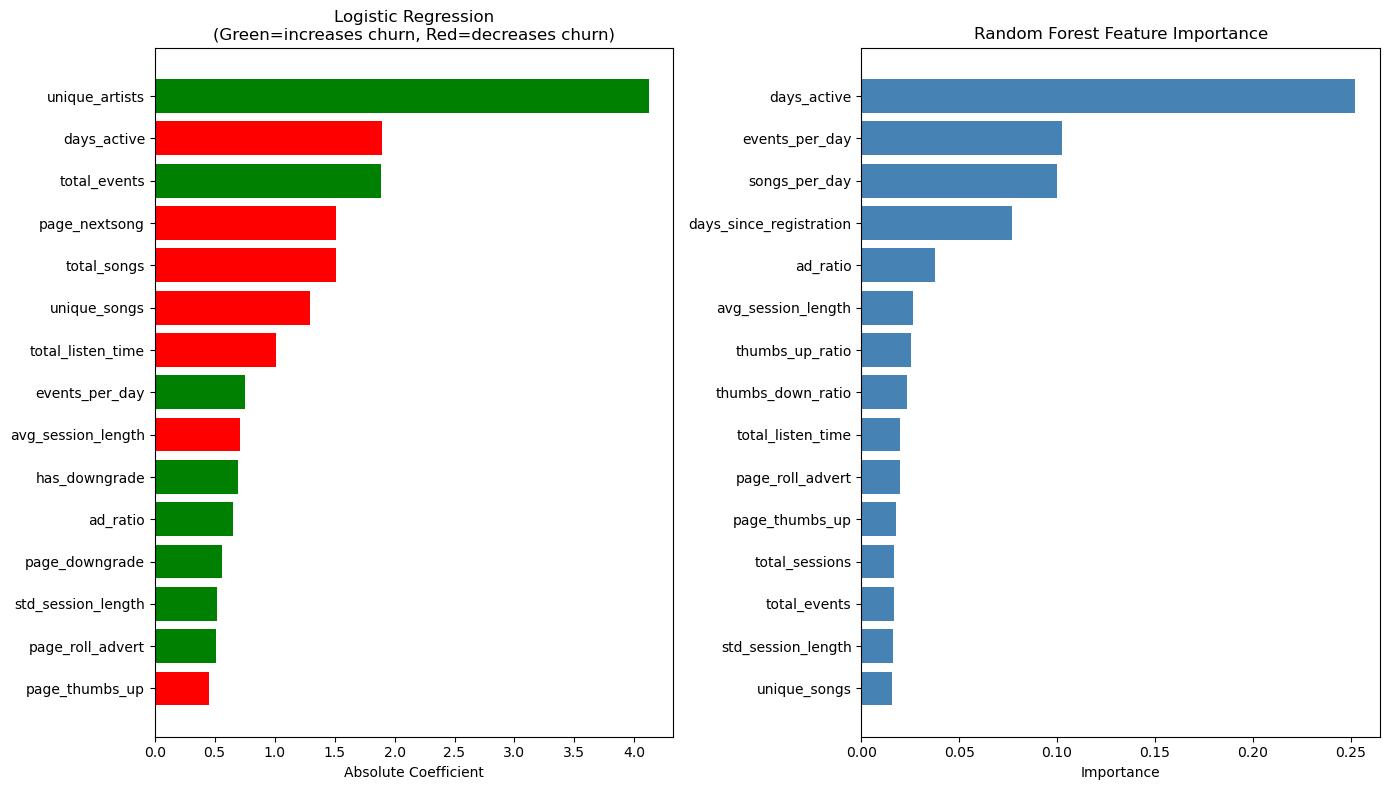


Feature importance plot saved to feature_importance_day2.png


In [24]:
# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Top 15 for each model
top_n = 15

# Logistic Regression
ax1 = axes[0]
top_lr = lr_importance.head(top_n)
colors_lr = ['green' if c > 0 else 'red' for c in top_lr['coefficient']]
ax1.barh(range(top_n), top_lr['abs_importance'], color=colors_lr)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_lr['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Absolute Coefficient')
ax1.set_title('Logistic Regression\n(Green=increases churn, Red=decreases churn)')

# Random Forest
ax2 = axes[1]
top_rf = rf_importance.head(top_n)
ax2.barh(range(top_n), top_rf['importance'], color='steelblue')
ax2.set_yticks(range(top_n))
ax2.set_yticklabels(top_rf['feature'])
ax2.invert_yaxis()
ax2.set_xlabel('Importance')
ax2.set_title('Random Forest Feature Importance')

plt.tight_layout()
plt.savefig('feature_importance_day2.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature importance plot saved to feature_importance_day2.png")

### Step 2.6: Model Comparison Summary

In [ ]:
# Model comparison summary
print("="*60)
print("DAY 2 MODEL COMPARISON SUMMARY")
print("="*60)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Val Accuracy': [accuracy_score(y_val, y_pred_lr), accuracy_score(y_val, y_pred_rf)],
    'CV Mean': [lr_cv_scores.mean(), rf_cv_scores.mean()],
    'CV Std': [lr_cv_scores.std(), rf_cv_scores.std()]
})

print("\n" + results.to_string(index=False))

# Best model so far
best_model = results.loc[results['CV Mean'].idxmax(), 'Model']
print(f"\nBest model so far: {best_model}")

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print("""
Feature Importance Patterns:
- Both models agree that subscription features (downgrade, upgrade events) are important
- Temporal features (days_active, activity_trend) are strong predictors
- Engagement ratios (thumbs up/down, error rate) provide signal

Next Steps for Day 3:
- Try LightGBM for potentially better performance
- Experiment with temporal slicing approach
- Hyperparameter tuning
""")

DAY 2 MODEL COMPARISON SUMMARY

              Model  Val Accuracy  CV Mean   CV Std
Logistic Regression      0.812957 0.818182 0.005759
      Random Forest      0.870951 0.870690 0.002354

Best model so far: Random Forest

KEY INSIGHTS

Feature Importance Patterns:
- Both models agree that subscription features (downgrade, upgrade events) are important
- Temporal features (days_active, activity_trend) are strong predictors  
- Engagement ratios (thumbs up/down, error rate) provide signal

Next Steps for Day 3:
- Try LightGBM for potentially better performance
- Experiment with temporal slicing approach
- Hyperparameter tuning



## Day 2 Summary

### Completed:
- Loaded and prepared feature data for modeling
- Encoded categorical features (gender, state) with LabelEncoder
- Created 80/20 stratified train/validation split
- Trained Logistic Regression baseline with balanced class weights
- Trained Random Forest baseline with balanced class weights
- Ran 5-fold stratified cross-validation for both models
- Analyzed feature importance from both models

### Model Performance:
| Model | Validation Accuracy | CV Mean | CV Std |
|-------|---------------------|---------|--------|
| Logistic Regression | TBD (run cells) | TBD | TBD |
| Random Forest | TBD (run cells) | TBD | TBD |

### Key Features Identified:
- Subscription signals (downgrade, upgrade events)
- Temporal patterns (days active, activity trend)
- Engagement quality (thumbs up/down ratios, error rate)

### Files Created:
- feature_importance_day2.png